In [1]:
from copy import deepcopy
from datetime import date, datetime
import json
import re

import pandas as pd
import numpy as np
import pyomo.environ as pyo
from thefuzz import process, fuzz

import sys

from app.model import UnitCommitmentModel, DispatchOptions, DispatchConfig

In [2]:
config = DispatchConfig(
    dispatch_type="preideal"
)

# Fechas mucha termica
# DISPATCH_DATE = date(2024,4,18)
# DISPATCH_DATE = date(2024,4,19)
DISPATCH_DATE = date(2024,4,25)
# DISPATCH_DATE = date(2024,4,26)

# Mucha hidro
# DISPATCH_DATE = date(2024,5,5)
# DISPATCH_DATE = date(2024,5,6)
# DISPATCH_DATE = date(2024,5,7)

# Promedio
# DISPATCH_DATE = date(2024,9,5)
# DISPATCH_DATE = date(2024,9,6)
# DISPATCH_DATE = date(2024,9,7)


# Al azar
# DISPATCH_DATE = date(2024,3,11)
# DISPATCH_DATE = date(2024,8,10)
# DISPATCH_DATE = date(2024,3,23)
# DISPATCH_DATE = date(2024,2,15)
# DISPATCH_DATE = date(2024,5,25)
# DISPATCH_DATE = date(2024,6,9)

price_pattern = r"P(\d+)"
dispo_pattern = r"DISCONF(\d+)"

# 1. Load data

## 1.1 Load initial data

In [3]:
if config.dispatch_type == "ideal":
    dispo_come = pd.read_csv('data/DispoCome_resource.csv', parse_dates=["datetime"], engine="pyarrow")
dispo = pd.read_csv('data/dispo_declarada.csv', parse_dates=["datetime"], engine="pyarrow")
ofertas = pd.read_csv('data/ofertas.csv', parse_dates=["Date"], engine="pyarrow")
demanda = pd.read_csv('data/demaCome.csv', parse_dates=["datetime"], engine="pyarrow")
agc_asignado = pd.read_csv('data/agc_asignado.csv', parse_dates=["datetime"], engine="pyarrow")
parametros_plantas = pd.read_csv("data/parametros_plantas.csv")

# Precio bolsa
precio_bolsa = pd.read_csv('data/precio_bolsa/precio_bolsa_2024.csv', parse_dates=["datetime"], engine="pyarrow")
precio_bolsa["precio_bolsa"] = precio_bolsa["precio_bolsa"]*1E3

In [4]:
output = []
MO = []
CC = {}
cc_price = {}
cc_dispo = {}
prices = {}
with open(f"data/oferta_inicial/OFEI{DISPATCH_DATE.month:0>2}{DISPATCH_DATE.day:0>2}.txt", "r") as file:
    for line in file.readlines():
        line = line.strip()
        if "PAP" in line:
            output.append(line)
        if "MO" in line:
            mo_line = line.split(",")
            if len(mo_line) > 2 and "MO" in mo_line[1]:
                MO.append(mo_line)
        if (conf:=re.findall(price_pattern, line)) and "CC" in line:
            fline = line.split(",")
            cc_price[f"{fline[0].strip()}_{conf[0]}"] = float(fline[2])
            if CC.get(fline[0].strip()):
                CC[fline[0].strip()].append(f"{fline[0].strip()}_{conf[0]}")
            else:
                CC[fline[0].strip()] = [f"{fline[0].strip()}_{conf[0]}"]
        # Disponibilidad CC
        if (conf:=re.findall(dispo_pattern, line)) and "CC" in line:
            fline = line.split(",")
            cc_dispo[f"{fline[0].strip()}_{conf[0]}"] = [int(disp) for disp in fline[2:]]

        # Extract prices
        if "P" in line:
            pri = line.split(",")
            if len(pri) == 3 and " P" in pri[1] and not "u" in pri[1].lower() and not "a" in pri[1].lower():
                prices[pri[0]] = float(pri[2])*1E-3

            
            
precio_arranque = pd.DataFrame(
    [
        line.split(",")
        for line in output
        if not "usd" in line.lower()
    ],
    columns=["resource", "type", "price"]
)
precio_arranque["price"] = precio_arranque["price"].astype(float)

# Minimo operativo
minimo_operativo = pd.DataFrame(
    MO,
    columns=["resource", "type", ] + list(range(24))
)
minimo_operativo = minimo_operativo.set_index(["resource", "type"]).stack().reset_index()
minimo_operativo.columns = ["resource", "type", "hour", "minimo_operativo"]
minimo_operativo["datetime"] = pd.to_datetime(DISPATCH_DATE) + pd.to_timedelta(minimo_operativo["hour"], unit="h")
minimo_operativo["minimo_operativo"] = minimo_operativo["minimo_operativo"].astype(float)
minimo_operativo

,resource,type,hour,minimo_operativo,datetime
0,SALVAJINA,MO,0,0.0,2024-04-25 00:00:00
1,SALVAJINA,MO,1,50.0,2024-04-25 01:00:00
2,SALVAJINA,MO,2,0.0,2024-04-25 02:00:00
3,SALVAJINA,MO,3,0.0,2024-04-25 03:00:00
4,SALVAJINA,MO,4,50.0,2024-04-25 04:00:00
...,...,...,...,...,...
187,URRA,MO,19,59.0,2024-04-25 19:00:00
188,URRA,MO,20,59.0,2024-04-25 20:00:00
189,URRA,MO,21,59.0,2024-04-25 21:00:00
190,URRA,MO,22,59.0,2024-04-25 22:00:00


## 1.2 Filter data by date

In [5]:
dispo = dispo[
    (dispo.datetime.dt.date == DISPATCH_DATE) &
    (dispo["resource_name"].notnull())
]
dispo = dispo.drop_duplicates(subset=["resource_name", "datetime"])

ofertas = ofertas[ofertas.Date.dt.date == DISPATCH_DATE]
agc_asignado = agc_asignado[agc_asignado["datetime"].dt.date == DISPATCH_DATE]
demanda = demanda[demanda["datetime"].dt.date == DISPATCH_DATE]
precio_bolsa = precio_bolsa[precio_bolsa["datetime"].dt.date == DISPATCH_DATE]


In [6]:
if config.dispatch_type == "ideal":
    dispo_come = dispo_come[
        (dispo_come.datetime.dt.date == DISPATCH_DATE) &
        (dispo_come["resource_name"].notnull())
    ]
    dispo_come = dispo_come.drop_duplicates(subset=["resource_name", "datetime"])
    for gen in dispo["resource_name"].unique():
        if gen in dispo_come["resource_name"].unique():
            serie = dispo_come[
                (dispo_come["resource_name"] == gen)
            ]
            serie = serie.set_index("datetime").reindex(
                pd.date_range(
                    start=DISPATCH_DATE,
                    end=DISPATCH_DATE + pd.Timedelta(days=1),
                    freq="1h", inclusive="left"
                )).fillna(0)
            dispo.loc[dispo["resource_name"] == gen, "dispo"] = serie["dispo"].values
        else:
            print(f"no existe el generador {gen} en disponibilidad comercial para el {DISPATCH_DATE}. Se asignará en 0")
            dispo.loc[dispo["resource_name"] == gen, "dispo"] = 0


## 1.3. Extract prices from OFEI

### 1.3.1. Map names

In [7]:
price_bid_map = {
    gen: process.extractOne(
        query=gen.lower(),
        choices=dispo["resource_name"].unique(),
        scorer=fuzz.token_sort_ratio,
        processor=lambda x: x.lower().replace(" ", ""),
        score_cutoff=70,
    )[0]
    for gen in prices.keys()
}
prices = {
    price_bid_map[gen]: price
    for gen, price in prices.items()
}

### 1.3.2. Transform bids

In [8]:
ofertas["Value"] = ofertas.apply(lambda x: prices.get(x["resource_name"],float(x["Value"])), axis=1)
ofertas

,Date,resource_code,resource_name,resource_gen_type,resource_source_type,resource_company_code,resource_company_name,Value
33739,2024-04-25,TFL1,FLORES I CC,TERMICA,GAS,TMFG,PRIME TERMOFLORES S.A.S. E.S.P.,570.000
33740,2024-04-25,TEC1,TERMOEMCALI CC,TERMICA,ACPM,TEMG,TERMOEMCALI I S.A. E.S.P.,1763.980
33741,2024-04-25,TDR1,TERMODORADA 1,TERMICA,JET-A1,EPMG,EMPRESAS PUBLICAS DE MEDELLIN E.S.P.,2291.748
33742,2024-04-25,TCDT,TERMOCANDELARIA CC,TERMICA,GAS,TCIG,TERMOCANDELARIA S.A.S. - E.S.P.,471.990
33743,2024-04-25,TCBE,TERMOCARIBE III 1,TERMICA,GLP,TCBG,TERMO CARIBE S.A.S. E.S.P.,840.000
...,...,...,...,...,...,...,...,...
33805,2024-04-25,JAGS,JAGUAS,HIDRAULICA,AGUA,ISGG,ISAGEN S.A. E.S.P.,85.275
33806,2024-04-25,HMLG,MIEL I,HIDRAULICA,AGUA,ISGG,ISAGEN S.A. E.S.P.,85.275
33807,2024-04-25,HMIN,ESCUELA DE MINAS,HIDRAULICA,AGUA,HDPG,HIDROELECTRICA DEL ALTO PORCE S.A.S. E.S.P.,81.000
33808,2024-04-25,GVIO,GUAVIO,HIDRAULICA,AGUA,ENDG,ENEL COLOMBIA SA ESP,150.000


In [9]:
# ofertas.loc[ofertas["resource_name"].str.contains("TEBSA"),"Value"] = 500.000
# ofertas[ofertas["resource_name"].str.contains("TEBSA")]

In [10]:
# import numpy as np
# dispo.loc[dispo["resource_name"].str.contains("VALLE"),"dispo"] = np.array([239,  1,  1,  1,  1,  1,  1,  1,  1,  1,  239,  239,  239,  239,  239,  239,  239,  239,  239,  239,  239,  239,  239,  239])*1E3
# ofertas.loc[ofertas["resource_name"].str.contains("VALLE"),"Value"] = 500.000

In [11]:
# ofertas.loc[ofertas["resource_name"].str.contains("TEBSA"),"Value"] = 1514.537

In [12]:
# ofertas.head()

## 1.4. Get Initial conditions

In [13]:
# Load Initial condition by plant and Units
with open(f"data/condicion_inicial/{DISPATCH_DATE}/dCondIniP{DISPATCH_DATE.month:0>2}{DISPATCH_DATE.day:0>2}.txt", "r") as file:
    data = file.readlines()
    data = [line.strip().split(",") for line in data]
    headers = data.pop(0)
condicion_inicial_planta = pd.DataFrame(data, columns=headers)

with open(f"data/condicion_inicial/{DISPATCH_DATE}/dCondIniU{DISPATCH_DATE.month:0>2}{DISPATCH_DATE.day:0>2}.txt", "r") as file:
    data = file.readlines()
    data = [line.strip().split(",") for line in data]
    headers = data.pop(0)

# Transform dataframe
condicion_inicial_unidad = pd.DataFrame(data, columns=headers)
# Generate name mappes
condicion_inicial_map = {
    gen: process.extractOne(
        query=gen.lower(),
        choices=dispo["resource_name"].unique(),
        scorer=fuzz.token_sort_ratio,
        processor=lambda x: x.lower().replace(" ", ""),
        # score_cutoff=70,
    )[0]
    for gen in condicion_inicial_planta.Recurso.unique()
}
# FIX some maps
condicion_inicial_map.update({
    "FLORES IV":"FLORES 4 CC",
    "TSIERRA": "TERMOSIERRA CC",
    "GUAJIR21": "GUAJIRA 2"
})
condicion_inicial_planta["Recurso"] = condicion_inicial_planta["Recurso"].apply(lambda x: condicion_inicial_map.get(x, x))

## 1.5 Generating new resources for CC plants

### 1.5.1. New CC resources

In [14]:
# DROP previous CC
CC_MAP = {
    gen: process.extractOne(
        query=gen.lower(),
        choices=dispo["resource_name"].unique(),
        scorer=fuzz.partial_token_sort_ratio,
        processor=lambda x: x.lower().replace(" ", ""),
        score_cutoff=70,
    )[0]
    for gen in CC.keys()
}
CC_MAP

dispo = dispo[~dispo["resource_name"].isin(list(CC_MAP.values()))]
ofertas = ofertas[~ofertas["resource_name"].isin(list(CC_MAP.values()))]

In [15]:
# INCLUDING CC RESOURCE in DISPO and OFERTAS
new_cc_resources = pd.DataFrame(cc_dispo).stack().reset_index()
new_cc_resources.columns = ["hours", "resource_name", "dispo"]
new_cc_resources["dispo"] = new_cc_resources["dispo"]*1e3
new_cc_resources["hours"] = new_cc_resources["hours"].astype(int)
new_cc_resources["datetime"] = pd.to_datetime(DISPATCH_DATE) + pd.to_timedelta(new_cc_resources["hours"], unit="h")
new_cc_resources["gen_type"] = "TERMICA"
new_cc_resources["dispatched"] = "DESPACHADO CENTRALMENTE"
new_cc_resources["company_activity"] = "GENERACIÓN"
new_cc_resources.pop("hours")


# OFERTAS

new_cc_bid = pd.DataFrame(cc_price, index=[1]).stack().reset_index(drop=False)
new_cc_bid.columns = ["index_", "resource_name", "Value"]
new_cc_bid["Value"] = new_cc_bid["Value"].apply(lambda x: x*1E-3)
# new_cc_bid["datetime"] = pd.to_datetime(DISPATCH_DATE) + pd.to_timedelta(new_cc_bid["hours"], unit="h")
new_cc_bid["resource_gen_type"] = "TERMICA"
new_cc_bid["Date"] = DISPATCH_DATE
# new_cc_bid["dispatched"] = "DESPACHADO CENTRALMENTE"
# new_cc_bid["company_activity"] = "GENERACIÓN"
_ = new_cc_bid.pop("index_")



In [16]:
dispo = pd.concat([dispo, new_cc_resources], axis=0)
ofertas = pd.concat([ofertas, new_cc_bid], axis=0)

### 1.5.2 Adding units for each CC resource

In [17]:
CC_MAP_inv = {
    v: k
    for k, v in CC_MAP.items()
}

In [18]:
dcondIniPlant = condicion_inicial_planta[condicion_inicial_planta.Recurso.isin(CC_MAP.values())]
dcondIniPlant.loc[:,"Recurso"] = dcondIniPlant["Recurso"].apply(lambda x: CC_MAP_inv.get(x, x))
dcondIniPlant.loc[:,"dispatched_conf"] = dcondIniPlant.loc[:,"Conf_Pini-1"].apply(lambda x: int(re.findall(r"\d+", x)[0]))
# dcondIniPlant = dcondIniPlant[dcondIniPlant["dispatched_conf"]>0]
dcondIniPlant


/tmp/ipykernel_711324/4149212414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcondIniPlant.loc[:,"dispatched_conf"] = dcondIniPlant.loc[:,"Conf_Pini-1"].apply(lambda x: int(re.findall(r"\d+", x)[0]))


,Recurso,Tipo,Pini,Conf_Pini-1,Disp_Pini-1,Gpini-2,Gpini-1,T_CONF_Pini-1,Estado_Pini-1,Bloque_Pini-1,TCE_Pendiente,CONF_Entrada,CONF_Salida,dispatched_conf
5,FLORES4CC,T,1,1_GAS,445,445,445,203,NA,0,0,NA,NA,1
6,FLORESICC,T,1,1_GAS,160,160,160,9,NA,0,0,NA,NA,1
22,TERMOCANDELARIACC,T,1,4_GAS,555,555,555,923,NA,0,0,NA,NA,4
24,TERMOCENTROCC,T,1,0_GAS,0,0,0,6624,NA,0,0,NA,NA,0
25,TEBSABCC,T,1,10_GAS,791,791,791,755,NA,0,0,NA,NA,10
26,TERMOEMCALICC,T,1,2_ACP,208,208,208,285,NA,0,0,NA,NA,2
29,TERMOSIERRACC,T,1,9_ACP,352,352,352,6,NA,0,0,NA,NA,9
30,TERMOVALLECC,T,1,1_GAS,239,239,239,192,NA,0,0,NA,NA,1


In [19]:
initial_condition_df = pd.DataFrame()
for plant, cc_plants in deepcopy(CC).items():
    filtered_init_condition = dcondIniPlant.query("Recurso == @plant").reset_index()
    dispatched_conf = filtered_init_condition.loc[0,"dispatched_conf"]
    if filtered_init_condition.loc[0,"dispatched_conf"] != 0:
        filtered_init_condition.loc[0,"Recurso"] = f"{plant}_{dispatched_conf}"
        dispatched_config = f"{plant}_{dispatched_conf}"
        cc_plants.pop(cc_plants.index(dispatched_config))
    to_concat = [
        filtered_init_condition 
        for _ in cc_plants
    ]
    if to_concat:
        filtered_init_condition_ = pd.concat(to_concat)
        filtered_init_condition_["Recurso"] = cc_plants
        filtered_init_condition_["Gpini-1"] = 0
        filtered_init_condition = pd.concat([filtered_init_condition, filtered_init_condition_], ignore_index=True)
        filtered_init_condition = filtered_init_condition[~filtered_init_condition["Recurso"].isin([plant])]
    initial_condition_df = pd.concat([initial_condition_df, filtered_init_condition], ignore_index=True)


condicion_inicial_planta_termicas = condicion_inicial_planta[
    ~(condicion_inicial_planta["Tipo"] == "H") &
    ~(condicion_inicial_planta["Recurso"].isin(CC_MAP.values()))
]
initial_condition_df = pd.concat([initial_condition_df, condicion_inicial_planta_termicas], ignore_index=True)
initial_condition_df = initial_condition_df.astype({
    "T_CONF_Pini-1": int,
    "Gpini-1": float
})
    

## 1.6. Generating initial set to model

In [20]:
major_generators = ofertas.resource_name.unique()
generators = dispo.resource_name.unique()
timestamps = demanda["datetime"].to_dict().values()
# fuel_generators = dispo.query('resource_name in @major_generators and gen_type=="TERMICA"').resource_name.unique()
fuel_generators = dispo[
    (dispo["resource_name"].isin(major_generators)) &
    (dispo["gen_type"] == "TERMICA")
].resource_name.unique()


# Thermal gen
gen_on = initial_condition_df[initial_condition_df["Gpini-1"]!=0]["Recurso"].unique()
gen_off = list(set(fuel_generators) - set(gen_on))

In [21]:
"TERMOCARIBE III 1" in ofertas.resource_name.unique()

True

## 1.2. Get startup/shutdown costs

In [22]:
MO_map = {
    gen: results[0]
    for gen in minimo_operativo.resource.unique()
    if (results := process.extractOne(
        query=gen.lower(),
        choices=generators,
        # choices=major_generators.tolist(),
        scorer=fuzz.token_sort_ratio,
        processor=lambda x: x.lower().replace(" ", ""),
        score_cutoff=70,
    ))
}
minimo_operativo["resource"] = minimo_operativo["resource"].apply(lambda x: MO_map.get(x, x))
minimo_operativo

,resource,type,hour,minimo_operativo,datetime
0,SALVAJINA,MO,0,0.0,2024-04-25 00:00:00
1,SALVAJINA,MO,1,50.0,2024-04-25 01:00:00
2,SALVAJINA,MO,2,0.0,2024-04-25 02:00:00
3,SALVAJINA,MO,3,0.0,2024-04-25 03:00:00
4,SALVAJINA,MO,4,50.0,2024-04-25 04:00:00
...,...,...,...,...,...
187,URRA,MO,19,59.0,2024-04-25 19:00:00
188,URRA,MO,20,59.0,2024-04-25 20:00:00
189,URRA,MO,21,59.0,2024-04-25 21:00:00
190,URRA,MO,22,59.0,2024-04-25 22:00:00


In [23]:
generators_pap_map = {
    gen: process.extractOne(
        query=gen.lower(),
        choices=precio_arranque.resource.unique(),
        scorer=fuzz.partial_token_sort_ratio,
        processor=lambda x: x.lower().replace(" ", ""),
        score_cutoff=70,
    )[0]
    for gen in fuel_generators
}

cold_start = {}
for gen in fuel_generators:
    gen_name_mapped = generators_pap_map[gen]
    gen_pap=precio_arranque[
        (precio_arranque["resource"] == gen_name_mapped) &
        (precio_arranque.type.str.contains("F"))
    ]["price"].values[0]
    cold_start[gen] = float(gen_pap)
  


In [24]:
# Valores en MWh
Pmax = dispo.query("resource_name in @generators").set_index(["resource_name","datetime"]).sort_index()["dispo"]*1E-3
Pmin = minimo_operativo.set_index(["resource", "datetime"]).sort_index()["minimo_operativo"]
beta = ofertas.query("resource_name in @generators").set_index(["resource_name"]).sort_index()["Value"]*1E3
agc_indexed = agc_asignado.set_index(["recurso", "datetime"])["agc"]*1E-3

# Pmax.loc[agc_indexed.index] = Pmax.loc[agc_indexed.index] -  agc_indexed

In [25]:
demand_pronos =pd.read_csv(f"data/preideal_dispatch/{DISPATCH_DATE}.txt", header=None)
demand_pronos = demand_pronos.iloc[:, 1:].sum().values

In [26]:
demand_pronos = dict(zip(demanda["datetime"], demand_pronos))

In [27]:
Ton = initial_condition_df.set_index(["Recurso"]).query("Recurso in @gen_on")["T_CONF_Pini-1"]
# Ton = Ton[Ton.index.isin(fuel_generators)]

In [28]:
z_on_t0_minus_1 = {
    gen : 1
    for gen in initial_condition_df[initial_condition_df["Gpini-1"]>0]["Recurso"].unique()
    
}


### 1.7 Fix fuel-fire generators to check

In [29]:
fixed_fuel_fire = pd.read_csv(f"data/preideal_dispatch/{DISPATCH_DATE}.txt", header=None)
fixed_fuel_fire.columns = ["generator"] + list(range(24))
fixed_fuel_fire = fixed_fuel_fire.set_index("generator").stack().reset_index()
fixed_fuel_fire.columns = ["generator", "hour", "gen"]
fixed_fuel_fire["datetime"] = pd.to_datetime(DISPATCH_DATE) + pd.to_timedelta(fixed_fuel_fire["hour"], unit="h")

# Fix generation
fixed_fuel_fired_map = {}
for gen in fixed_fuel_fire.generator.unique():
    if not (
        str(gen).startswith("AG_") or
        str(gen).startswith("M") or
        str(gen).startswith("GD") or
        str(gen).startswith("AR")
    ):
        choice = process.extractOne(
            query=gen.lower(),
            choices=generators,
            scorer=fuzz.partial_token_sort_ratio,
            processor=lambda x: x.lower().replace(" ", ""),
            # score_cutoff=60,
        )[0]
        if choice in fuel_generators:
            fixed_fuel_fired_map[gen] = choice
        else:
            ...
            # print(f"{gen} select {choice} but is not a fuel generator")
            
        

In [30]:
# --- RAMPS ---
with open("data/ramps.json", "r") as file:
    ramps = json.load(file)

In [31]:
DEMANDA = demand_pronos if config.dispatch_type == "preideal" else (demanda.set_index("datetime")["dema"]*1E-3).astype(int)
MAX_MIN_OP = 1 if config.dispatch_type == "preideal" else 0
TMG = parametros_plantas[parametros_plantas["generador"].isin(fuel_generators)].set_index("generador")["TMG"].astype(int)


In [32]:
beta.loc[beta.index=="CALIMA"] = 0
DEMANDA = {k:v-3 for k,v in DEMANDA.items()}

In [33]:
set_data = {
    "G": fuel_generators,
    "T": timestamps,
    "I": generators,
    "combined_cycle": list(CC.keys()),
    "excluded_resource": CC,
    "gen_on": gen_on,
    "gen_off": gen_off,
}



param_data = {
    "Pmax" : Pmax.apply(lambda x: np.round(x,0)),
    # "Pmin" : Pmin,
    "Pmin" : {},
    "beta" : beta,
    "cold_start" : cold_start,
    "demand" : DEMANDA,
    "Ton": Ton,
    "z_on_t0_minus_1":z_on_t0_minus_1,
    "TMG": TMG,
    "ramp_up": ramps,
    "ramp_down":ramps,
    "max_min_op": MAX_MIN_OP
}


In [34]:
model = UnitCommitmentModel(config=config)
model.create_model(set_data=set_data, param_data=param_data)






# results = model.solve(solver="cplex", executable="solver/cplex")

# model._model.z.fix()

# results = model.solve(solver="cplex", executable="solver/cplex")

In [35]:
# # ===== WARNING FIXING VARIABLES =====
# for gen, model_gen_name in fix_fuel_fired_gen_.items():
#     # Filter data
#     serie = fixed_fuel_fire[fixed_fuel_fire["generator"]==gen]
#     serie["generator"] = model_gen_name
#     for k,v in serie.set_index(["generator", "datetime"])["gen"].to_dict().items():
#         model._model.pout[k].fix(v)
    

In [36]:
results = model.solve(solver="cbc")

In [37]:
expr = model._model.objective.expr()
print(f"F.obj: {expr:,.2f}")

F.obj: 20,219,405,806.00


In [38]:
mpo_xm = pd.read_csv(f"data/preideal_price/{DISPATCH_DATE}.txt", header=None)
mpo_xm = mpo_xm.iloc[0,1:].values

In [39]:
MPO = {
    ke.index(): pyo.value(dual_)
    for ke, dual_ in model._model.dual.items()
    if "power_balance" in ke.name
}

In [40]:
model._model.Pmin.default()

1

In [41]:
print(f" Hour  :  MPO_XM  - MPO Computed")
[
    f"{i:0>2}:00  : {mpo:2} -   {MPO[list(MPO.keys())[i]]:.0f}" for i,mpo in enumerate(mpo_xm)
]

 Hour  :  MPO_XM  - MPO Computed


['00:00  : 160114 -   160114',
 '01:00  : 160114 -   160114',
 '02:00  : 150000 -   150000',
 '03:00  : 150000 -   150000',
 '04:00  : 150000 -   150000',
 '05:00  : 160114 -   160114',
 '06:00  : 160114 -   160114',
 '07:00  : 160114 -   160114',
 '08:00  : 160114 -   160114',
 '09:00  : 160114 -   160114',
 '10:00  : 160114 -   160114',
 '11:00  : 180000 -   180000',
 '12:00  : 180000 -   180000',
 '13:00  : 180000 -   180000',
 '14:00  : 190000 -   190000',
 '15:00  : 228980 -   228980',
 '16:00  : 234728 -   234728',
 '17:00  : 228980 -   228980',
 '18:00  : 600000 -   280000',
 '19:00  : 600000 -   280000',
 '20:00  : 280000 -   280000',
 '21:00  : 228980 -   228980',
 '22:00  : 180000 -   180000',
 '23:00  : 160114 -   160114']

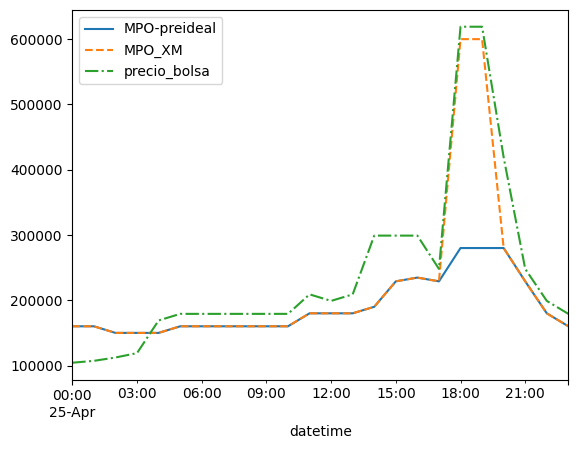

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
pd.DataFrame(data=MPO, index=[f"MPO-{config.dispatch_type.value}"]).T.plot(kind="line",ax=ax)
pd.DataFrame(data=mpo_xm, index=timestamps, columns=["MPO_XM"]).plot(kind="line", ax=ax, linestyle='--')

precio_bolsa.plot(kind="line", x="datetime", y="precio_bolsa", ax=ax, linestyle='-.')
plt.show()
# pd.DataFrame(data=mpo_xm, index=timestamps, columns=["MPO_XM"]).plot(kind="line", ax=ax, linestyle='--')

In [61]:
for k,v in model._model.pout["SOGAMOSO",:].expanded_items():
    print(k, v.value) 

('SOGAMOSO', Timestamp('2024-04-25 00:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 01:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 02:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 03:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 04:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 05:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 06:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 07:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 08:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 09:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 10:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 11:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 12:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 13:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 14:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 15:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 16:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 17:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04-25 18:00:00')) 0.0
('SOGAMOSO', Timestamp('2024-04

In [59]:
for k,v in model._model.Pmin["PRADO",:].expanded_items():
    print(k, v) 

('PRADO', Timestamp('2024-04-25 00:00:00')) 1
('PRADO', Timestamp('2024-04-25 01:00:00')) 1
('PRADO', Timestamp('2024-04-25 02:00:00')) 1
('PRADO', Timestamp('2024-04-25 03:00:00')) 1
('PRADO', Timestamp('2024-04-25 04:00:00')) 1
('PRADO', Timestamp('2024-04-25 05:00:00')) 1
('PRADO', Timestamp('2024-04-25 06:00:00')) 1
('PRADO', Timestamp('2024-04-25 07:00:00')) 1
('PRADO', Timestamp('2024-04-25 08:00:00')) 1
('PRADO', Timestamp('2024-04-25 09:00:00')) 1
('PRADO', Timestamp('2024-04-25 10:00:00')) 1
('PRADO', Timestamp('2024-04-25 11:00:00')) 1
('PRADO', Timestamp('2024-04-25 12:00:00')) 1
('PRADO', Timestamp('2024-04-25 13:00:00')) 1
('PRADO', Timestamp('2024-04-25 14:00:00')) 1
('PRADO', Timestamp('2024-04-25 15:00:00')) 1
('PRADO', Timestamp('2024-04-25 16:00:00')) 1
('PRADO', Timestamp('2024-04-25 17:00:00')) 1
('PRADO', Timestamp('2024-04-25 18:00:00')) 1
('PRADO', Timestamp('2024-04-25 19:00:00')) 1
('PRADO', Timestamp('2024-04-25 20:00:00')) 1
('PRADO', Timestamp('2024-04-25 21

In [60]:
for k,v in model._model.Pmax["PRADO",:].expanded_items():
    print(k, v) 

('PRADO', Timestamp('2024-04-25 00:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 01:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 02:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 03:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 04:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 05:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 06:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 07:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 08:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 09:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 10:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 11:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 12:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 13:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 14:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 15:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 16:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 17:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 18:00:00')) 42.0
('PRADO', Timestamp('2024-04-25 19:00:00')) 42.0
('PRADO', Timestamp(

In [46]:
model._model.G.display()

G : fuel-fired Generators
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   75 : {'TESORITO', 'CARTAGENA 1', 'CARTAGENA 2', 'CARTAGENA 3', 'GECELCA 32', 'GECELCA 3', 'MERILECTRICA 1', 'PAIPA 1', 'PAIPA 2', 'PAIPA 3', 'PAIPA 4', 'PROELECTRICA 1', 'PROELECTRICA 2', 'BARRANQUILLA 3', 'BARRANQUILLA 4', 'TERMOCARIBE III 1', 'TERMODORADA 1', 'GUAJIRA 1', 'GUAJIRA 2', 'TERMONORTE', 'TASAJERO 1', 'TASAJERO 2', 'TERMOYOPAL 1', 'TERMOYOPAL 2', 'TERMOYOPAL G3', 'TERMOYOPAL G4', 'TERMOYOPAL G5', 'ZIPAEMG 2', 'ZIPAEMG 3', 'ZIPAEMG 4', 'ZIPAEMG 5', 'TERMOSIERRACC_7', 'TERMOSIERRACC_8', 'TERMOSIERRACC_1', 'TERMOSIERRACC_2', 'TERMOSIERRACC_13', 'TERMOSIERRACC_14', 'TERMOSIERRACC_3', 'TERMOSIERRACC_4', 'TERMOSIERRACC_5', 'TERMOSIERRACC_6', 'TERMOSIERRACC_9', 'TERMOSIERRACC_10', 'TERMOSIERRACC_11', 'TERMOSIERRACC_12', 'TERMOCENTROCC_1', 'TERMOCENTROCC_2', 'TERMOCENTROCC_3', 'TERMOCENTROCC_4', 'TERMOCENTROCC_5', 'TEBSABCC_9', 'TEBSABCC_10',

In [47]:
model._model.pout.display()

pout : Power output of generator g in time period t
    Size=8376, Index=I*T
    Key                                                               : Lower : Value  : Upper : Fixed : Stale : Domain
                                 ('AGUA FRESCA', 2024-04-25 00:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                                 ('AGUA FRESCA', 2024-04-25 01:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                                 ('AGUA FRESCA', 2024-04-25 02:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                                 ('AGUA FRESCA', 2024-04-25 03:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                                 ('AGUA FRESCA', 2024-04-25 04:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                                 ('AGUA FRESCA', 2024-04-25 05:00:00) :     0 :    2.0 :  None : False : False : NonNegativeReals
                       

In [48]:
model._model.Pmin.display()

Pmin : Minimum power bid of generator g
    Size=8376, Index=I*T, Domain=NonNegativeReals, Default=1, Mutable=False
    Key : Value
